In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! cp  /content/drive/MyDrive/mixed-signal-snns-main-cleapup/snn_utils.py .
import snn_utils
! cp  /content/drive/MyDrive/mixed-signal-snns-main-cleapup/utils.py .
import utils
! cp  /content/drive/MyDrive/mixed-signal-snns-main-cleapup/loss.py .
import loss
! cp  /content/drive/MyDrive/mixed-signal-snns-main-cleapup/recurrent/analog_synapses.py .
import analog_synapses
! cp  /content/drive/MyDrive/mixed-signal-snns-main-cleapup/recurrent/decolle_model.py .
import decolle_model
! cp  /content/drive/MyDrive/mixed-signal-snns-main-cleapup/recurrent/spike_functions.py .
import spike_functions
! cp  /content/drive/MyDrive/mixed-signal-snns-main-cleapup/recurrent/neuron_models.py .
import neuron_models
! cp  /content/drive/MyDrive/mixed-signal-snns-main-cleapup/recurrent/non_linear_decolle_model.py .
import non_linear_decolle_model

In [3]:
from neuron_models import *

In [4]:
import torch

device = torch.device('cuda') #cpu/ cuda (available one)

gen_train = snn_utils.get_mnist_loader(100, Nparts=1, train=True)
gen_test = snn_utils.get_mnist_loader(100, Nparts=1, train=False)

T = 100 #duration of sequence
data, target = next(loss.iter_mnist(gen_train, T=T))

net = non_linear_decolle_model.LenetREDECOLLE(input_shape = data.shape[2:], mlp_neurons = [150,120], num_conv_layers=0, num_mlp_layers=2, alpha=[.95],beta=[.92] ,lc_ampl=.5, out_channels=10, lif_layer_type = [LIFLayer]*len([150])+[RecLIFLayer]*len([150])+[LIFLayer]*len([120])).to(device)

net
data_d = data.to(device)
target_d = target.to(device)
net.init_parameters(data_d.transpose(0,1))

100%|██████████| 9912422/9912422 [00:00<00:00, 150047318.66it/s]

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 121989621.17it/s]


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 47578006.15it/s]


Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4613835.98it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



In [5]:
opt = torch.optim.Adamax(net.get_trainable_parameters(), lr=1e-5, betas=[0., .95])

for e in range(20):
    accuracy=[]
    error = []
    for data, label in loss.iter_mnist(gen_train, T=T):
        net.train()
        loss_hist = 0
        data_d = data.to(device)
        label_d = label.to(device)
        net.init(data_d.transpose(0,1), burnin=10)
        readout = 0
        for n in range(T):
            st, rt, ut = net.forward(data_d[n])
            loss_tv = loss.decolle_loss(rt, label_d[n])
            loss_tv.backward()
            opt.step()
            opt.zero_grad()
            loss_hist += loss_tv
            readout += rt[-1]
        error += (readout.argmax(axis=1)!=label_d[-1].argmax(axis=1)).float()
        accuracy+=(readout.argmax(axis=1)==label_d[-1].argmax(axis=1)).float()
    print('Training Error', torch.mean(torch.Tensor(error)).data)
    print('Training accuracy', torch.mean(torch.Tensor(accuracy)).data)
    print('Epoch', e, 'Loss', loss_hist.data)
    #PATH = '/YOUR/DESIRED/PATH.pth'
    #torch.save(net.state_dict(), PATH)

Training Error tensor(0.8817)
Training accuracy tensor(0.1183)
Epoch 0 Loss tensor(12.8428, device='cuda:0')
Training Error tensor(0.8650)
Training accuracy tensor(0.1350)
Epoch 1 Loss tensor(12.4984, device='cuda:0')
Training Error tensor(0.8500)
Training accuracy tensor(0.1500)
Epoch 2 Loss tensor(12.2825, device='cuda:0')
Training Error tensor(0.8433)
Training accuracy tensor(0.1567)
Epoch 3 Loss tensor(12.0928, device='cuda:0')
Training Error tensor(0.8383)
Training accuracy tensor(0.1617)
Epoch 4 Loss tensor(11.7853, device='cuda:0')
Training Error tensor(0.8333)
Training accuracy tensor(0.1667)
Epoch 5 Loss tensor(11.6130, device='cuda:0')
Training Error tensor(0.8233)
Training accuracy tensor(0.1767)
Epoch 6 Loss tensor(11.4533, device='cuda:0')
Training Error tensor(0.8250)
Training accuracy tensor(0.1750)
Epoch 7 Loss tensor(11.4107, device='cuda:0')
Training Error tensor(0.8333)
Training accuracy tensor(0.1667)
Epoch 8 Loss tensor(11.2846, device='cuda:0')
Training Error tens

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
#from resources.plotcm import plot_confusion_matrix

error = []
accuracy=[]
y_pred = []
y_true = []


for data, label in loss.iter_mnist(gen_test, T=T):
        loss_hist = 0
        data_d = data.to(device)
        label_d = label.to(device)
        net.init(data_d.transpose(0,1), burnin=100)
        readout = 0
        with torch.no_grad():
          for n in range(T):
             st, rt, ut=net.forward(data_d[n])
             loss_tv = loss.decolle_loss(rt, label_d[n])

             loss_hist += loss_tv
             readout += rt[-1]
          output = (readout.argmax(axis=1)).data.cpu().numpy()
          y_pred.extend(output)
          labels =(label_d[-1].argmax(axis=1)).data.cpu().numpy()
          y_true.extend(labels)
          accuracy+=(readout.argmax(axis=1)==label_d[-1].argmax(axis=1)).float()
          error += (readout.argmax(axis=1)!=label_d[-1].argmax(axis=1)).float()
print('Testing Error', torch.mean(torch.Tensor(error)).data)
print('Testing accuracy', torch.mean(torch.Tensor(accuracy)).data)
accuracy=torch.mean(torch.Tensor(accuracy)).item()
# Build confusion matrix
classes = ('O', '1', '2', '3', '4',
        '5', '6', '7', '8', '9')
cm = confusion_matrix(y_true, y_pred)

cm

Testing Error tensor(1.)
Testing accuracy tensor(0.)


array([[0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 0]])

<ipython-input-9-fed7657d2960>:7: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


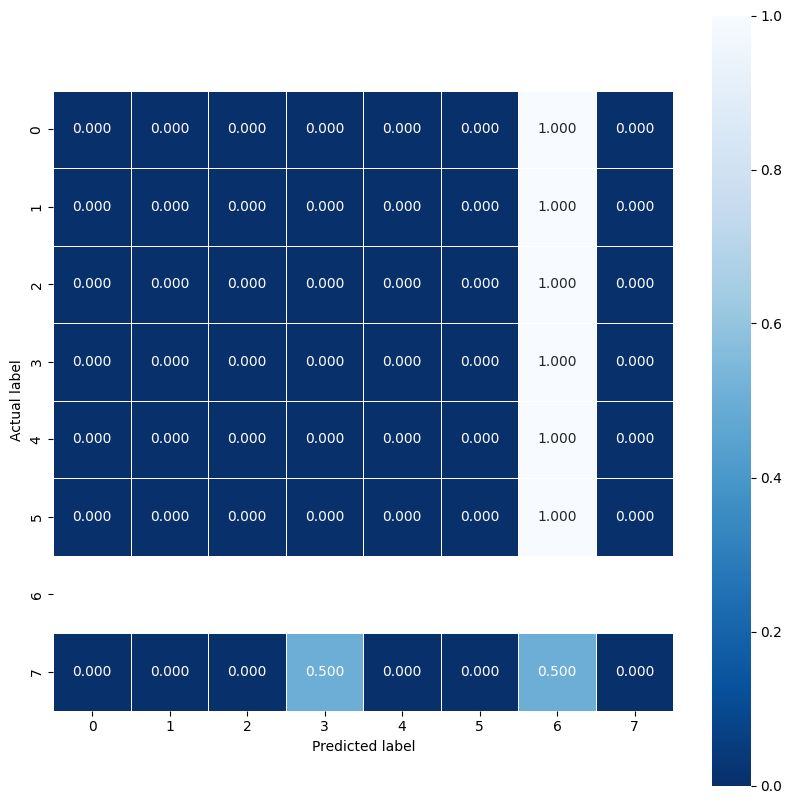

In [ ]:
# Used for Confusion Matrix
from sklearn import metrics
import seaborn as sns
import numpy as np

cm = metrics.confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,10))
sns.heatmap(cm_normalized, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
#plt.savefig('/YOUR/DESIRED/PATH.svg')